In [1]:
import sys
sys.path.append("..")
import logging
import random
import torch
import numpy as np
from torchvision import transforms
from federated_learning.FLCustomDataset import FLCustomDataset
from federated_learning.FederatedLearning import FederatedLearning
from federated_learning.helper import utils

In [2]:
CONFIG_PATH = '../configs/defaults.yml'
configs = utils.load_config(CONFIG_PATH)
neptune_enable, log_enable, output_dir = False, False, '/tmp'
fl = FederatedLearning(
        configs['runtime']['batch_size'], 
        configs['runtime']['test_batch_size'], 
        configs['runtime']['lr'], 
        configs['runtime']['reg'],
        configs['runtime']['momentum'], 
        neptune_enable, log_enable, 
        configs['log']['interval'], 
        output_dir, 
        configs['runtime']['random_seed'])

In [3]:
total_num_workers = configs['mnist']['total_number_users']
workers_idx = ["worker_" + str(i) for i in range(total_num_workers)]
fl.create_workers(workers_idx)

In [4]:
train_raw_data = utils.preprocess_mnist(
        utils.load_mnist_data_train(
            configs['data']['MNIST_PATH'], 
            configs['runtime']['mnist_data_percentage']))
train_raw_sorted = utils.sort_mnist(train_raw_data)
train_dataset = utils.get_mnist_dataset(train_raw_sorted)

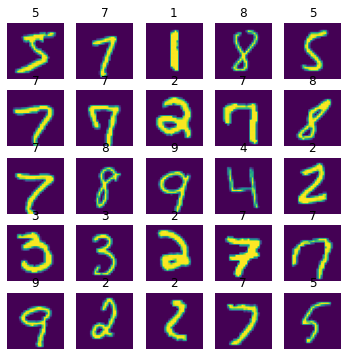

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(train_raw_data['y'][i+i*i*95])
    plt.imshow(train_raw_data['x'][i+i*i*95])

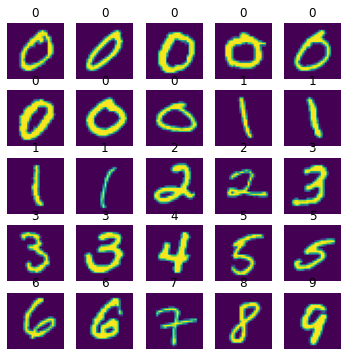

In [6]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(train_raw_sorted['y'][i+i*i*95])
    plt.imshow(train_raw_sorted['x'][i+i*i*95])

In [7]:
logging.info("Start splitting the data into {} shards...".format(total_num_workers))
shards_of_data_x = np.split(train_raw_sorted['x'], total_num_workers)
shards_of_data_y = np.split(train_raw_sorted['y'], total_num_workers)

from collections import defaultdict
train_splitted_data = defaultdict(lambda: dict())
for ii, ww_id in enumerate(workers_idx):
    train_splitted_data[ww_id]['x'] = shards_of_data_x[ii]
    train_splitted_data[ww_id]['y'] = shards_of_data_y[ii]

In [10]:
import syft as sy
fed_train_datasets = fl.create_mnist_fed_datasets(train_splitted_data)
fed_train_dataloaders = dict()
for ww_id, fed_dataset in fed_train_datasets.items():
    dataloader = sy.FederatedDataLoader(
        fed_dataset, batch_size=configs['runtime']['batch_size'], shuffle=False, drop_last=True)
    fed_train_dataloaders[ww_id] = dataloader

In [21]:
from random import sample
from copy import deepcopy
fl.create_server_model()
selected_users_num = configs['mnist']['selected_users_num']
workers_to_be_used = sample(workers_idx, selected_users_num)
logging.info("Selected users for this round: {}".format(workers_to_be_used))

logging.info("Update workers model in this round...")
workers_model = dict()
for worker_id in workers_to_be_used:
    workers_model[worker_id] = deepcopy(fl.server_model)

In [25]:
print(type(workers_model))
print("yes") if isinstance(workers_model, dict) else print("no")
for ii, (iii, iiii) in enumerate(workers_model.items()):
    print("{}, {}, {}".format(ii, iii, type(iiii)))
    
fl.getback_model(fl.workers_model)
for ii, (iii, iiii) in enumerate(workers_model.items()):
    print("{}, {}, {}".format(ii, iii, type(iiii)))

<class 'dict'>
yes
0, worker_55, <class 'federated_learning.FLNet.FLNet'>
1, worker_34, <class 'federated_learning.FLNet.FLNet'>
2, worker_40, <class 'federated_learning.FLNet.FLNet'>
3, worker_57, <class 'federated_learning.FLNet.FLNet'>
4, worker_69, <class 'federated_learning.FLNet.FLNet'>
5, worker_86, <class 'federated_learning.FLNet.FLNet'>
6, worker_46, <class 'federated_learning.FLNet.FLNet'>
7, worker_65, <class 'federated_learning.FLNet.FLNet'>
8, worker_79, <class 'federated_learning.FLNet.FLNet'>
9, worker_71, <class 'federated_learning.FLNet.FLNet'>
10, worker_63, <class 'federated_learning.FLNet.FLNet'>
11, worker_9, <class 'federated_learning.FLNet.FLNet'>
12, worker_91, <class 'federated_learning.FLNet.FLNet'>
13, worker_90, <class 'federated_learning.FLNet.FLNet'>
14, worker_84, <class 'federated_learning.FLNet.FLNet'>
15, worker_41, <class 'federated_learning.FLNet.FLNet'>
16, worker_60, <class 'federated_learning.FLNet.FLNet'>
17, worker_85, <class 'federated_learnin

In [ ]:
print(fl.train_data['x'].reshape(-1,784).shape)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(fl.train_data['x'].reshape(-1,784))
figure = plt.figure(figsize=(15, 8))
plt.scatter(proj[:, 0], proj[:,1], c = fl.train_data['y'], cmap="Paired")
plt.ylim([-8, 8])
plt.colorbar(ticks=range(10))

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
embeddings = TSNE(n_jobs=2).fit_transform(fl.train_data['x'].reshape(-1, 784))
figure = plt.figure(figsize=(15,8))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=fl.train_data['y'], cmap=plt.cm.get_cmap("jet", 10), marker=".")
plt.clim(-0.5, 9.5)